In [1]:
import pickle as pkl
import numpy as np
from itertools import chain
import tensorflow_probability as tfp
import matplotlib.pyplot as plt

from src.models.train_emos import train_emos, train_and_test_emos
from src.visualization.pit import make_cpit_diagram_emos, make_cpit_hist_emos 
from src.visualization.brier_score import make_brier_skill_plot, brier_plot
from src.models.get_data import get_tensors, get_normalized_tensor
from src.models.emos import EMOS
from src.visualization.scoring_tables import make_table
from src.visualization.twcrpss_plot import make_twcrpss_plot
from src.models.emos import EMOS
from src.visualization.reliability_diagram import make_reliability_diagram, make_reliability_diagram_sklearn, make_reliability_and_sharpness
from src.training.training import load_model
from src.visualization.plot_forecasts import plot_forecast_cdf, plot_forecast_pdf, plot_weight_mixture, plot_forecast_pdf_i

2024-03-27 09:14:57.542935: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-27 09:14:57.569645: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-27 09:14:57.569675: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-27 09:14:57.570348: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-27 09:14:57.574371: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-27 09:14:57.574836: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [16]:
folder = '/net/pc200239/nobackup/users/hakvoort/models/emos/'

base_model = load_model(folder + 'trunc_normal/tn_crps_.pkl')
base_model = load_model(folder + 'trunc_normal_features/tnf_crps__epochs600_folds_1_2.pkl')
print(base_model)

Using given parameters for Truncated Normal distribution
Using given parameters for Truncated Normal distribution with features
EMOS Model Information:
Loss function: loss_CRPS_sample (Samples: 100)
Forecast distribution: distr_trunc_normal_features
Parameters:
  a_tn: [0.43781877]
  b_tn: [ 0.96098053 -0.01114134 -0.15016781  0.03635887  0.01139694]
  c_tn: [0.8354466]
  d_tn: [ 0.33230117 -0.12157276  0.36083695 -0.06131722 -0.4415567 ]
Features: wind_speed, press, kinetic, humid, geopot
Number of features: 5
Neighbourhood size: 11

Optimizer: Adam
Learning rate: 0.029999999329447746



In [17]:
ml_tn_gev_M13_STD1_C03 = load_model(folder + 'mixture_linear/mixturelinear_tn_gev_twcrps_mean13.0_std1.0_constant0.029999999329447746_epochs600.pkl')
m_tn_gev_M13_STD1_C03 = load_model(folder + 'mixture/mixture_tn_gev_twcrps_mean13.0_std1.0_constant0.029999999329447746_epochs600.pkl')

m_tn_ln_M13_STD1_C03 = load_model(folder + 'mixture/mixture_tn_ln_twcrps_mean13.0_std1.0_constant0.029999999329447746_epochs600.pkl')
ml_tn_ln_M13_STD1_C03 = load_model(folder + 'mixture_linear/mixturelinear_tn_ln_twcrps_mean13.0_std1.0_constant0.029999999329447746_epochs600.pkl')

ml_tn_gev_M13_STD1 = load_model(folder + 'mixture_linear/mixturelinear_tn_gev_twcrps_mean13.0_std1.0_epochs600.pkl')

ml_tn_gev_M13_STD1_C02 = load_model(folder + 'mixture_linear/mixturelinear_tn_gev_twcrps_mean13.0_std1.0_constant0.019999999552965164_epochs600.pkl')

tn_M13_STD1_C03 = load_model(folder + 'trunc_normal/tn_twcrps_mean13.0_std1.0_constant0.029999999329447746_epochs600.pkl')

ml_tn_gev_M13_STD4 = load_model(folder + 'mixture_linear/mixturelinear_tn_gev_twcrps_mean13.0_std4.0_epochs600.pkl')

tttt = {'ml_tn_gev_M13_STD1': ml_tn_gev_M13_STD1} #, 'ml_tn_gev_M13_STD1_C03':ml_tn_gev_M13_STD1_C03}

test = load_model(folder + "mixture_linear/mixturelinear_tn_gev_twcrps_mean13.0_std1.0_constant0.009999999776482582_epochs600.pkl")

test_2 = load_model(folder + 'mixture_linear/mixturelinear_tn_gev_twcrps_mean13.0_std1.0_constant0.029999999329447746_epochs600.pkl')

test_3 = load_model(folder + 'mixture_linear/mixturelinear_tn_gev_twcrps_mean13.0_std1.5_constant0.029999999329447746_epochs600.pkl')

test_base = load_model(folder + 'mixture_linear/mixturelinear_tn_gev_crps__epochs600_folds_1_2.pkl')

mixture_base = load_model(folder + 'mixture/mixture_tn_gev_crps__epochs600_folds_1_2.pkl')

mixture_gev_spatial = load_model(folder + "mixture_linear/mixturelinear_tn_gev_sv_crps__epochs600_folds_1_2.pkl")

tn_features = load_model(folder + 'trunc_normal_features/tnf_crps__epochs600_folds_1_2.pkl')

ml_tnf_gevf = load_model(folder + 'mixture_linear/mixturelinear_tnf_gev_crps__epochs600_folds_1_2.pkl')

test_dict = {'test_3': test_3, 'test_base': test_base, 'mixture_base': mixture_base, 'mixture_gev_spatial': mixture_gev_spatial, 'tn_features': tn_features, 'ml_tnf_gevf': ml_tnf_gevf}


all_models_dict = {'base_model': base_model, 'ml_tn_gev_M13_STD1': ml_tn_gev_M13_STD1, 'm_tn_gev_M13_STD1_C03': m_tn_gev_M13_STD1_C03, 'm_tn_gev_M13_STD1_C03': m_tn_gev_M13_STD1_C03, 'm_tn_ln_M13_STD1_C03': m_tn_ln_M13_STD1_C03, 'ml_tn_ln_M13_STD1_C03': ml_tn_ln_M13_STD1_C03, 'ml_tn_gev_M13_STD1_C02': ml_tn_gev_M13_STD1_C02, 'tn_M13_STD1_C03': tn_M13_STD1_C03, 'ml_tn_gev_M13_STD4': ml_tn_gev_M13_STD4}

Using given parameters for Truncated Normal distribution
Using given parameters for Generalized Extreme Value distribution
Using given weight parameters for weights in Mixture Linear distribution
Using given parameters for Truncated Normal distribution
Using given parameters for Generalized Extreme Value distribution
Using given weight parameter for Mixture distribution
Using given parameters for Truncated Normal distribution
Using given parameters for Log Normal distribution
Using given weight parameter for Mixture distribution
Using given parameters for Truncated Normal distribution
Using given parameters for Log Normal distribution
Using given weight parameters for weights in Mixture Linear distribution
Using given parameters for Truncated Normal distribution
Using given parameters for Generalized Extreme Value distribution
Using given weight parameters for weights in Mixture Linear distribution
Using given parameters for Truncated Normal distribution
Using given parameters for Gene

In [18]:
test_fold = 3
ignore = ['229', '285', '323']
X_test, y_test, variances_test = get_tensors(base_model.neighbourhood_size, base_model.feature_names, test_fold, ignore)
X_test = (X_test - base_model.feature_mean) / base_model.feature_std

print(X_test.shape)

(7780, 5)


In [19]:
for model_name, model in test_dict.items():
    print(model_name, model.forecast_distribution.has_negative_scale(X_test, variances_test))

test_3 False
test_base False
mixture_base False
mixture_gev_spatial False
tn_features False
ml_tnf_gevf False


In [20]:
print("CRPS base model", base_model.CRPS(X_test, y_test, variances_test, 5000).numpy())
for model_name, model in test_dict.items():
    print("CRPS ", model_name, model.CRPS(X_test, y_test, variances_test, 5000).numpy())

CRPS base model 0.8878648
CRPS  test_3 0.8926153
CRPS  test_base 0.8825783
CRPS  mixture_base 0.88706714
CRPS  mixture_gev_spatial 0.8872063
CRPS  tn_features 0.8883468
CRPS  ml_tnf_gevf 0.88659745


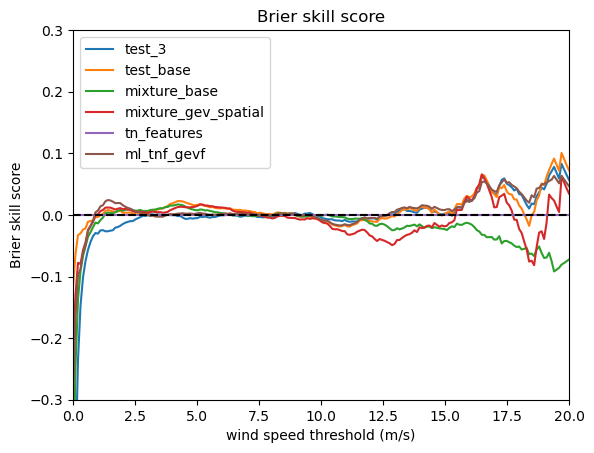

In [21]:
values = np.linspace(0, 20, 200)
ylim = [-0.3, 0.3]
make_brier_skill_plot(base_model, test_dict, X_test, y_test, variances_test, values, ylim=ylim)

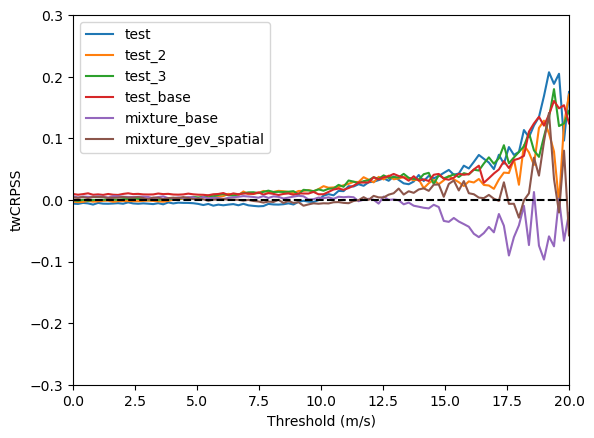

In [7]:
values = np.linspace(0, 20, 100)
ylim = [-0.3, 0.3]
make_twcrpss_plot(base_model, test_dict, X_test, y_test, variances_test, values, ylim=ylim)

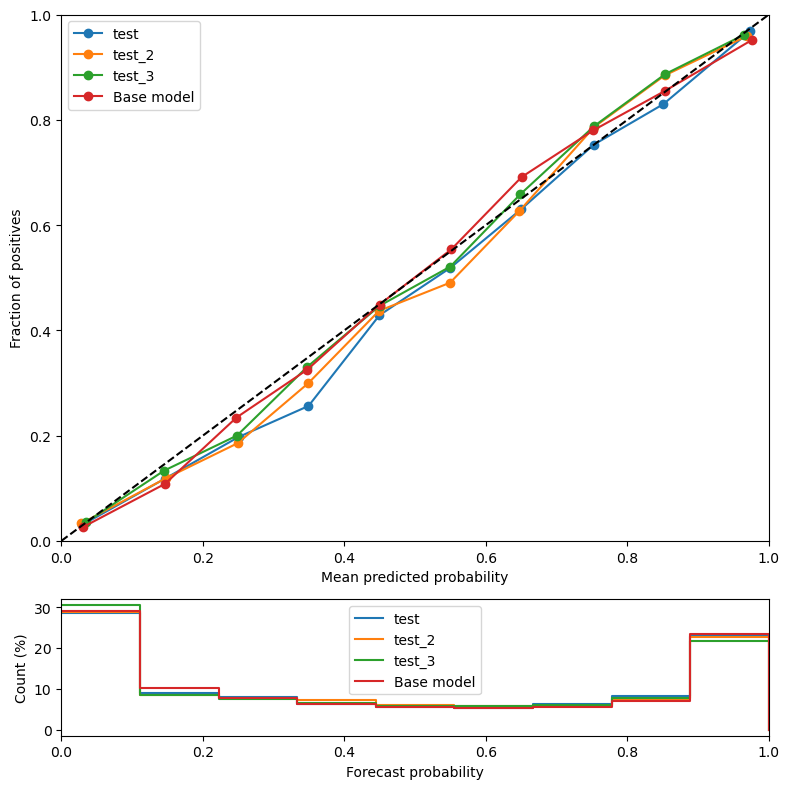

In [6]:
make_reliability_and_sharpness(test_dict, X_test, y_test, variances_test, 5, base_model=base_model)

In [9]:
x = 18
print("Base model: ", base_model.Brier_Score(X_test, y_test, variances_test, x).numpy())
print("ml_tn_gev_M13_STD1_C03: ", ml_tn_gev_M13_STD1_C03.Brier_Score(X_test, y_test, variances_test, x).numpy())
print("ml_tn_gev_M13_STD1: ", ml_tn_gev_M13_STD1.Brier_Score(X_test, y_test, variances_test, x).numpy())

Base model:  0.0015424276
ml_tn_gev_M13_STD1_C03:  0.0015117595
ml_tn_gev_M13_STD1:  0.0043912646


In [10]:
x = 18
samples = 20000
print("Base model: ", base_model.twCRPS(X_test, y_test, variances_test, x, samples).numpy())
print("ml_tn_gev_M13_STD1_C03: ", ml_tn_gev_M13_STD1_C03.twCRPS(X_test, y_test, variances_test, x, samples).numpy())
print("ml_tn_gev_M13_STD1: ", ml_tn_gev_M13_STD1.twCRPS(X_test, y_test, variances_test, x, samples).numpy())

Base model:  0.0023941956
ml_tn_gev_M13_STD1_C03:  0.002183225
ml_tn_gev_M13_STD1:  0.0022072846


In [7]:
# plot a gev distr with loc, scale and conc as parameters using tfp
loc = 0
scale = -1
conc = 0.1
gev = tfp.distributions.GeneralizedExtremeValue(loc=loc, scale=scale, concentration=conc)
n = 100

samples = gev.sample(n).numpy()
print(samples)




[ 0.29209962  0.37284872 -2.3255072  -0.17722243 -1.4896303  -0.44978145
  0.7534961   1.5195711   0.349626   -0.83653593 -1.8377837  -2.0595696
 -3.4300618  -0.04567101 -0.6858087  -8.007898    0.6193569   0.4695589
 -0.19780467  0.72073513  0.6433215  -1.157783   -2.5320559  -0.32448685
  0.18968739 -0.2871963  -1.6625487  -1.4690616  -0.6211946  -1.3718402
  0.22200847 -0.6052674   0.5871012  -0.09796624 -0.25163275 -1.3738211
  0.26565298 -0.37156716  0.7430137  -0.5916634   1.0119338   0.77270174
 -0.4538869   1.1011102  -1.0076562  -1.5511253  -0.090229   -1.6611403
 -0.4975581  -1.2248843  -0.78932357 -5.385898    0.4135549   0.8065299
 -1.0297202   0.5292638  -0.7404626  -1.1655836   0.4770255  -1.4528115
 -0.26362193 -0.48139036  0.48499912  0.5938709  -2.22324     0.35733795
 -0.22044346  0.4454807  -3.6450658   0.0258154  -2.2473366  -0.7455242
 -0.23694575 -1.4621415  -0.4866962  -0.19604746 -3.5460715  -3.1993296
 -1.0625801  -2.28182    -2.8357854  -4.4082036  -0.10657486